## Practice 1

### Víctor Galván Fraile

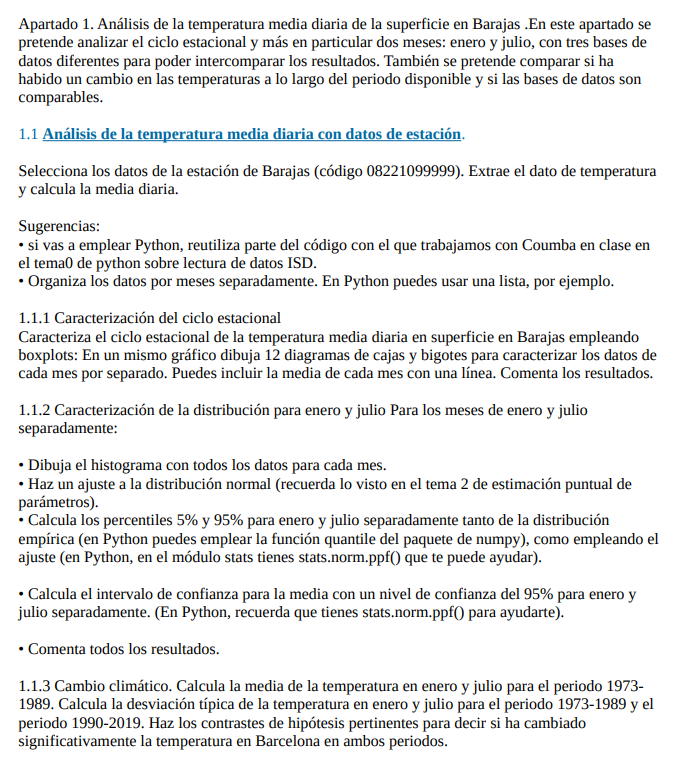

In [1]:
#Let's import first all the packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats as sts
from cartopy import crs as ccrs # Cartography library
import cmocean as cmo #Oceanographic library for colormaps

In [2]:
path_stations= r"C:\Users\ideapad 5 15ITL05\Desktop\Meteo UCM\1 cuatrimestre\Analisis de datos en meteorologia\Repaso python\Dia 3\isd-history.csv"
stations=pd.read_csv(path_stations)
station_name= 'BARAJAS'
stations[stations['STATION NAME']== station_name]

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
2909,082210,99999,BARAJAS,SP,NaN,LEMD,40.494,-3.567,609.6,19310102,20201004


In [3]:
#Next, we build up the code of the station (we now it already from the statement of the exercise)
station_code=str(stations.loc[(stations['STATION NAME']==station_name)]['USAF'].values[0]) + '-' + \
    str(stations.loc[(stations['STATION NAME']==station_name)]['WBAN'].values[0])
print('The code from the station of '+station_name+' is '+station_code+'.')

#Now, let's download the data from NOAA.
#More info of the data is located in https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt.
colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]
limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
yearInit=1973
yearEnd=2020

isd_data=pd.DataFrame(columns=colNames)
for iyr in range(yearInit, yearEnd, 1):
    fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station_code +'-'+ str(iyr)+'.gz'
    data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
    isd_data = pd.concat([isd_data,data])

The code from the station of BARAJAS is 082210-99999.


In [4]:
#Let's look up for missing data and scale the data
dictType={ colNames[i] : dataType[i] for i in range(12)}
isd_data = isd_data.astype(dictType,copy=True)

scaling_factor_temp= 10
isd_data = isd_data.replace(-9999,np.NaN)
isd_data['temp'] = isd_data["temp"].apply(lambda x: x/scaling_factor_temp)
isd_data.head()

,year,month,day,hour,temp,tempd,slp,windDir,windSpeed,cloud,pcp1h,pcp6h
0,1973,1,1,0,1.0,-10.0,NaN,0.0,0.0,0.0,NaN,NaN
1,1973,1,1,1,0.0,-20.0,NaN,330.0,20.0,NaN,NaN,NaN
2,1973,1,1,2,-1.0,-20.0,NaN,0.0,0.0,NaN,NaN,NaN
3,1973,1,1,3,-1.0,-20.0,10230.0,0.0,0.0,0.0,NaN,NaN
4,1973,1,1,4,-1.0,-20.0,NaN,0.0,0.0,NaN,NaN,NaN


In [5]:
#Having done these, let's divide the data period as said in the statement, as well as taking only the temperature data.
isd_data_firstperiod= isd_data[isd_data['year']<1991].iloc[:,0:5]
isd_data_secondperiod= isd_data[isd_data['year']>=1991].iloc[:,0:5]
print('First period shape: ',isd_data_firstperiod.shape)
print('Second period shape: ',isd_data_secondperiod.shape)
isd_data_firstperiod.tail()

daily_mean = isd_data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()

First period shape:  (151395, 5)
Second period shape:  (217646, 5)


In [6]:
months= ['January','February','March','April','May','June','July','August','September','October','November','December']
daily_mean_firstperiod = isd_data_firstperiod.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
monthly_mean_firstperiod = daily_mean_firstperiod.groupby(['year','month']).mean().reset_index()
monthly_mean_firstperiod['MONTH']= monthly_mean_firstperiod['month']-1 #for representation purposes
yearly_mean_firstperiod = monthly_mean_firstperiod.groupby(['year']).mean().reset_index()

daily_mean_secondperiod = isd_data_secondperiod.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
monthly_mean_secondperiod = daily_mean_secondperiod.groupby(['year','month']).mean().reset_index()
monthly_mean_secondperiod['MONTH']= monthly_mean_secondperiod['month']-1 #for representation purposes
yearly_mean_secondperiod = monthly_mean_secondperiod.groupby(['year']).mean().reset_index()
monthly_mean_firstperiod.tail()

,year,month,day,temp,MONTH
211,1990,8,16.0,25.305097,7
212,1990,9,15.5,21.347768,8
213,1990,10,16.0,14.511861,9
214,1990,11,15.5,8.075170,10
215,1990,12,16.0,3.618880,11


In [7]:
plt.style.use('seaborn')
def plotter_boxplots(data,x_axis_variable_name,y_axis_variable_name, xlabel,ylabel,title,labels_condition,ticks_labels, mean_line_condition,mean_data,x_variable_mean,mean_legend):
    fig,ax= plt.subplots()
    flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='green', alpha=0.5)
    sns.boxplot(x=x_axis_variable_name,y=y_axis_variable_name,data=data[[x_axis_variable_name,y_axis_variable_name]], palette='YlOrBr',showfliers = True, flierprops=flierprops)
    #sns.violinplot(x=x_axis_variable_name,y=y_axis_variable_name,data=data[[x_axis_variable_name,y_axis_variable_name]], palette='YlOrBr',showfliers = True, flierprops=flierprops)
    plt.xlabel(xlabel, fontsize= 14, fontweight='bold')
    plt.ylabel(ylabel, fontsize= 14, fontweight='bold')
    plt.title(title, fontsize= 16, fontweight='bold')
    if mean_line_condition==True:
        sns.lineplot(x=x_variable_mean,y=y_axis_variable_name,data=mean_data[[x_variable_mean,y_axis_variable_name]],label=mean_legend,legend='auto')   
        plt.legend(loc='best')
    if labels_condition==True:
        plt.xticks(ticks=np.arange(len(ticks_labels)),labels=ticks_labels, fontsize= 12, fontweight='bold',rotation=25)
    plt.show()

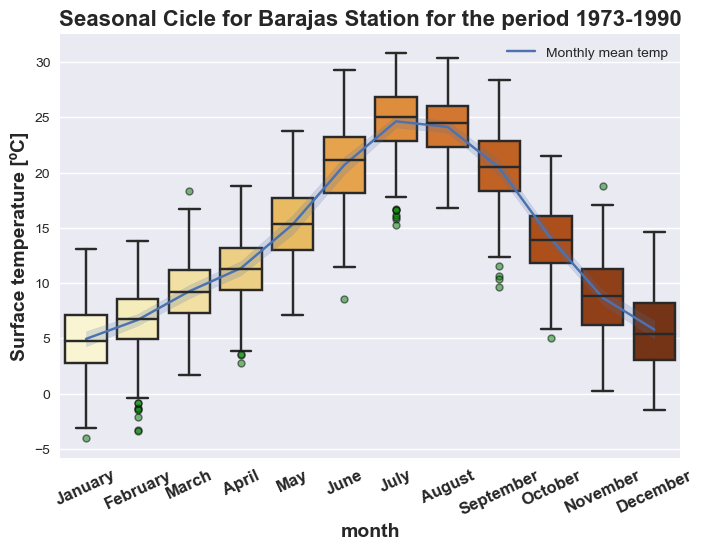

In [8]:
plotter_boxplots(daily_mean_firstperiod,'month','temp','month','Surface temperature [ºC]','Seasonal Cicle for Barajas Station for the period 1973-1990',True,months,True,monthly_mean_firstperiod,'MONTH','Monthly mean temp')

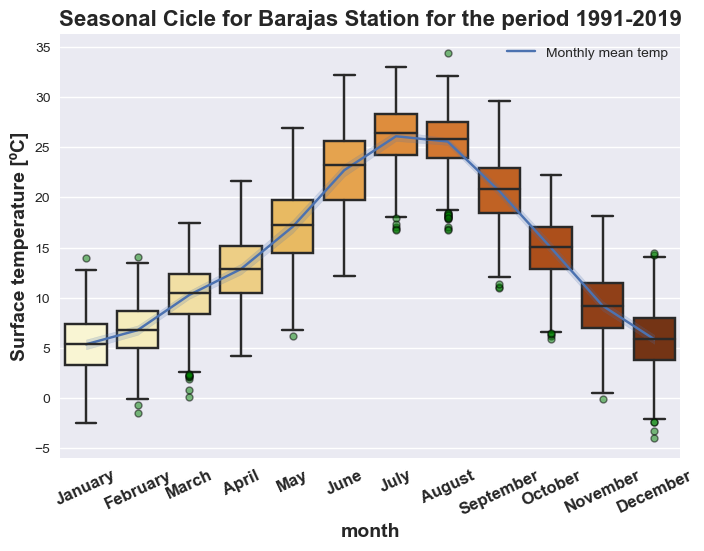

In [9]:
plotter_boxplots(daily_mean_secondperiod,'month','temp','month','Surface temperature [ºC]','Seasonal Cicle for Barajas Station for the period 1991-2019',True,months,True,monthly_mean_secondperiod,'MONTH','Monthly mean temp')

In [10]:
january_daily_mean_firstperiod= daily_mean_firstperiod[daily_mean_firstperiod['month']==1]
july_daily_mean_firstperiod= daily_mean_firstperiod[daily_mean_firstperiod['month']==7]
january_daily_mean_secondperiod= daily_mean_secondperiod[daily_mean_secondperiod['month']==1]
july_daily_mean_secondperiod= daily_mean_secondperiod[daily_mean_secondperiod['month']==7]

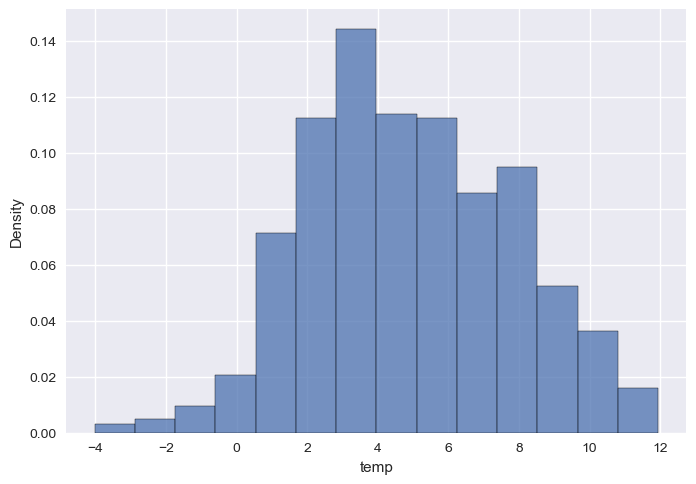

In [11]:
def histogram_plotter(data,variable):
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/15)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,kde = False, stat='density')

histogram_plotter(january_daily_mean_firstperiod,'temp')

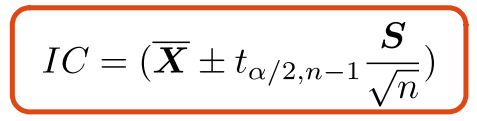


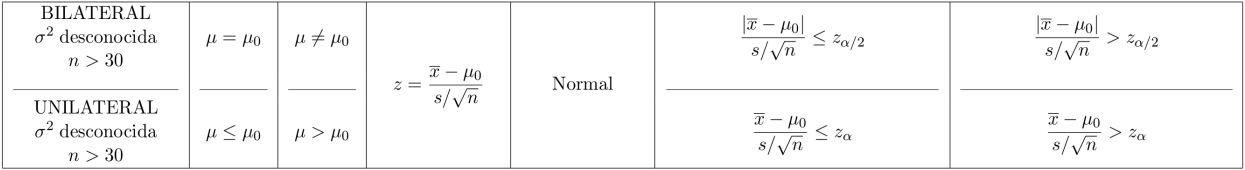

In [12]:
def histogram_plotter_with_normal_estimation(data:pd.DataFrame,variable:str,variable_name:str,title:str, verbose:bool=True) -> None:
    """
    description:
    --------------------------------------
    
    arguments:
        - data: entry dataframe
        - variable: name of the variable of study
        - title: plot title
        - verbose: True if you want the stats asociated with the variable
    """
    mean= np.mean(data[variable])
    std= np.std(data[variable])
    n= np.shape(data[variable])[0]
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/20)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,stat='density')
    normal_distribution= sts.norm.pdf(bins,mean,std)
    plt.plot(bins,normal_distribution,'red',label='Theoric')
    plt.legend(loc='best')
    plt.xlabel(variable_name)
    plt.title(title)
    plt.show()
    quantile_data= np.quantile(data[variable],(0.05,0.95))
    quantile_theoric= [sts.norm.ppf(0.05,mean,std),sts.norm.ppf(0.95,mean,std)]
    if verbose:
        print('Percentiles for the data are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_data[0],quantile_data[1]))
        print('Percentiles for the theoric distribution are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))
        print('Índice de Confianza del 95%')
        alfa=0.05
        #We must use the t-student distribution, beacuse with don't now the standard deviation of the data
        t_alpha_2= sts.t.ppf(1-alfa/2,n-1)
        ic= t_alpha_2*std/np.sqrt(n)
        print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))
        print('With scipy function:')
        ic_scipy=sts.t.interval(confidence=0.95,df=n-1,loc=mean,scale= std/np.sqrt(n))
        print(ic_scipy)

daily_mean    
january_daily_mean= daily_mean[daily_mean['month']==1]
july_daily_mean= daily_mean[daily_mean['month']==7]
periods= ['1973-2019','1973-1990','1990-2019']

## 1.Stats for whole period

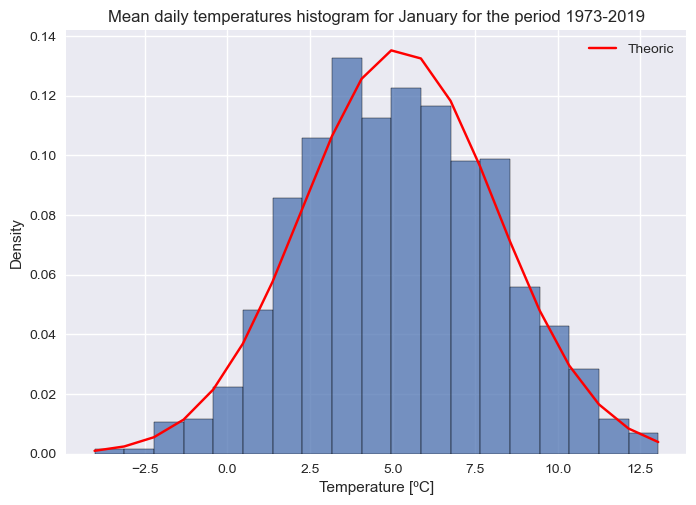

Percentiles for the data are: q(5%)=0.68 and q(95%)= 10.20
Percentiles for the theoric distribution are: q(5%)=0.38 and q(95%)= 10.05
Índice de Confianza del 95%
IC= [5.21+-0.15] (ºC)
With scipy function:
(5.061642316730847, 5.364033330142135)


In [13]:
histogram_plotter_with_normal_estimation(january_daily_mean,'temp','Temperature [ºC]','Mean daily temperatures histogram for January for the period '+periods[0])

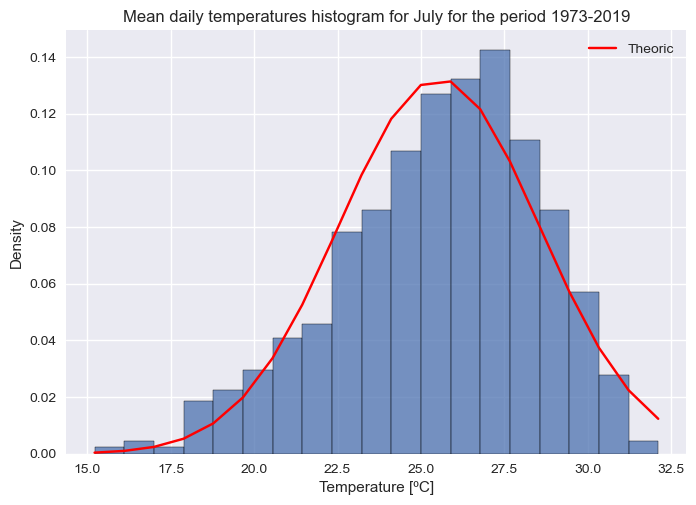

Percentiles for the data are: q(5%)=19.94 and q(95%)= 29.86
Percentiles for the theoric distribution are: q(5%)=20.58 and q(95%)= 30.50
Índice de Confianza del 95%
IC= [25.54+-0.16] (ºC)
With scipy function:
(25.383785005532744, 25.693858670064834)


In [14]:
histogram_plotter_with_normal_estimation(july_daily_mean,'temp','Temperature [ºC]','Mean daily temperatures histogram for July for the period '+periods[0])

## 2.Stats for the two subperiods

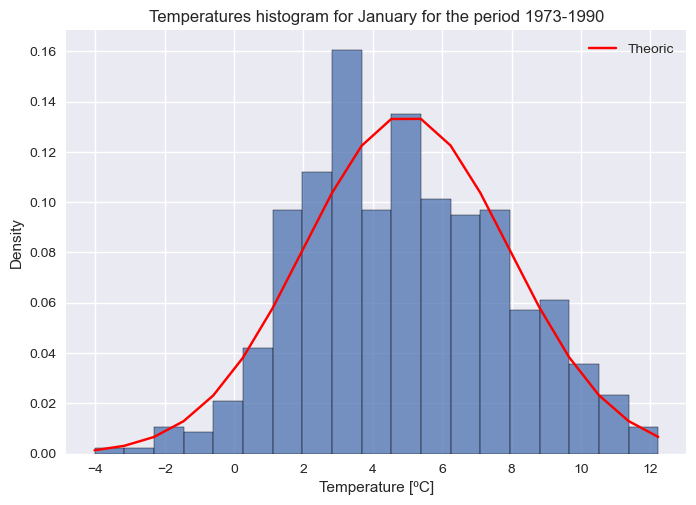

Percentiles for the data are: q(5%)=0.76 and q(95%)= 9.98
Percentiles for the theoric distribution are: q(5%)=0.08 and q(95%)= 9.84
Índice de Confianza del 95%
IC= [4.96+-0.25] (ºC)
With scipy function:
(4.715694291295337, 5.2090548166695925)


In [15]:
histogram_plotter_with_normal_estimation(january_daily_mean_firstperiod,'temp','Temperature [ºC]','Temperatures histogram for January for the period '+periods[1])

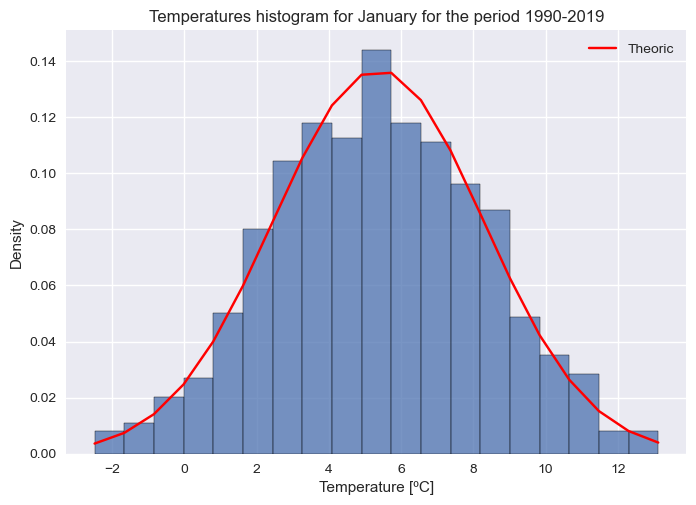

Percentiles for the data are: q(5%)=0.61 and q(95%)= 10.24
Percentiles for the theoric distribution are: q(5%)=0.57 and q(95%)= 10.16
Índice de Confianza del 95%
IC= [5.37+-0.19] (ºC)
With scipy function:
(5.1776024608974955, 5.559339342668907)


In [16]:
histogram_plotter_with_normal_estimation(january_daily_mean_secondperiod,'temp','Temperature [ºC]','Temperatures histogram for January for the period '+periods[2])

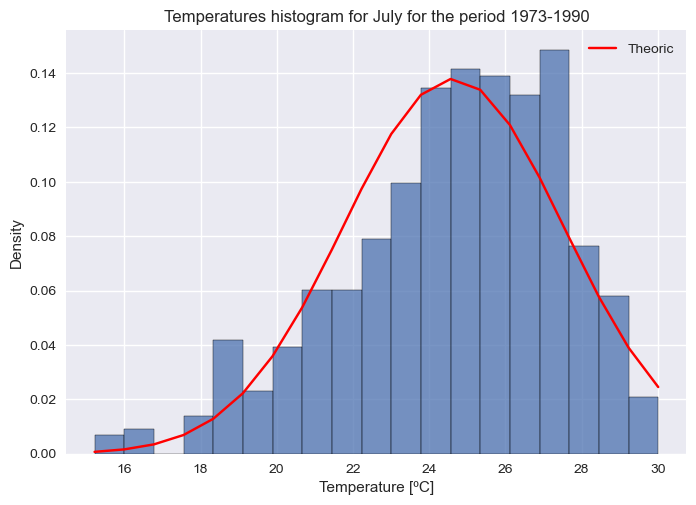

Percentiles for the data are: q(5%)=19.03 and q(95%)= 28.64
Percentiles for the theoric distribution are: q(5%)=19.88 and q(95%)= 29.40
Índice de Confianza del 95%
IC= [24.64+-0.24] (ºC)
With scipy function:
(24.396141159662044, 24.877306033139376)


In [17]:
histogram_plotter_with_normal_estimation(july_daily_mean_firstperiod,'temp','Temperature [ºC]','Temperatures histogram for July for the period '+periods[1])

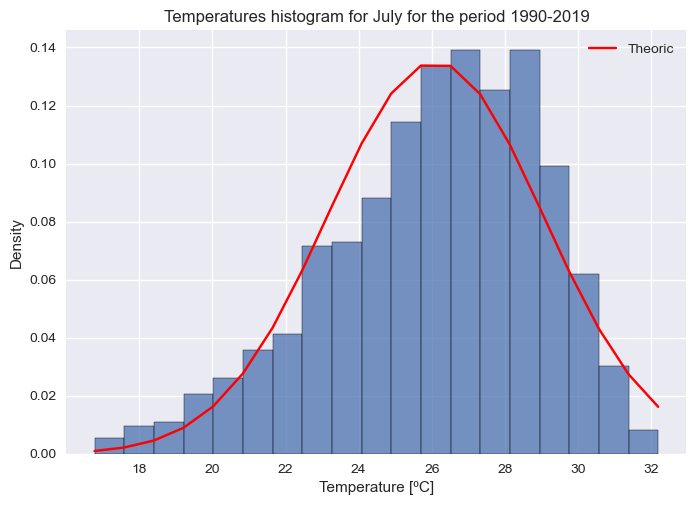

Percentiles for the data are: q(5%)=20.42 and q(95%)= 30.26
Percentiles for the theoric distribution are: q(5%)=21.24 and q(95%)= 30.96
Índice de Confianza del 95%
IC= [26.10+-0.19] (ºC)
With scipy function:
(25.90527380462026, 26.292215963747342)


In [18]:
histogram_plotter_with_normal_estimation(july_daily_mean_secondperiod,'temp','Temperature [ºC]','Temperatures histogram for July for the period '+periods[2])

### Cambio Climático estación de Barcelona

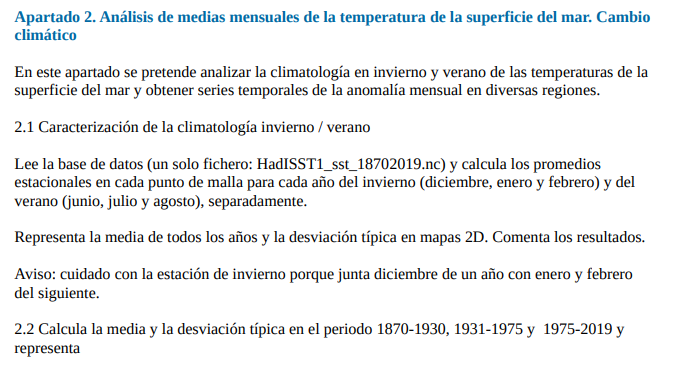

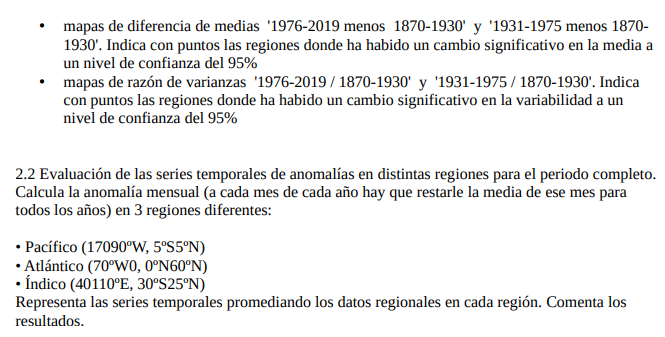

In [150]:
sst_path= r"C:\Users\ideapad 5 15ITL05\Desktop\Meteo UCM\1 cuatrimestre\Analisis de datos en meteorologia\Practica 1\Datos\HadISST1_sst_1870-2019.nc"
sst= xr.open_dataset(sst_path)
sst

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [151]:
jan= sst.sst[sst['time.season']=='DJF',:,:].squeeze()
seasons= np.mean(sst.groupby('time.season'))
seasons_std= np.std(sst.groupby('time.season'))

seasons

C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, season: 4)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst        (season, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan

In [152]:
winter= seasons.sst[seasons['season']=='DJF',:,:].squeeze()
winter_std= seasons_std.sst[seasons_std['season']=='DJF',:,:].squeeze()
summer= seasons.sst[seasons['season']=='JJA',:,:].squeeze()
summer_std= seasons_std.sst[seasons_std['season']=='JJA',:,:].squeeze()
summer

<xarray.DataArray 'sst' (latitude: 180, longitude: 360)>
array([[-1.8000008, -1.7999954, -1.7999954, ..., -1.8000007, -1.8000007,
        -1.8000007],
       [-1.7999927, -1.7999927, -1.7999927, ..., -1.7999927, -1.7999927,
        -1.7999927],
       [-1.7999926, -1.7999926, -1.7999926, ..., -1.7999926, -1.7999927,
        -1.7999927],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
    season     <U3 'JJA'

In [153]:
months= sst.groupby('time.month').mean()

In [154]:
months

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, month: 12)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan

In [155]:
#Manually
jan= months.sst[(months['month']==1)]
winter_manual= months.sst[(months['month']==12)|(months['month']<3)].mean(axis=0)
summer_manual= months.sst[(months['month']>5)&(months['month']<9)].mean(axis=0)
winter

<xarray.DataArray 'sst' (latitude: 180, longitude: 360)>
array([[-1.7999997, -1.7999997, -1.7999997, ..., -1.7999996, -1.7999996,
        -1.7999996],
       [-1.7999995, -1.7999995, -1.7999995, ..., -1.7999995, -1.7999995,
        -1.7999995],
       [-1.8000004, -1.8000002, -1.7999998, ..., -1.8000003, -1.8000004,
        -1.8000001],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
    season     <U3 'DJF'

Doing a quick analysis of the data, we see that the dates (hour and day) from which the data is collected differ from one to another. Anyway, we will take each of them as the mean SST value for each month.

In [156]:
lat=winter.latitude
lon=winter.longitude

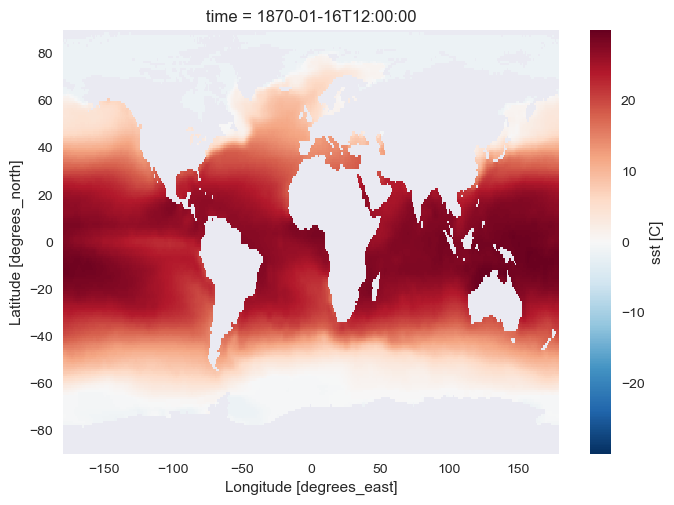

In [157]:
sst['sst'].sel(time='1870-01-16T12:00:00.000000000').plot()

In [158]:
def dibujo_1_mapa_cartopy(A,lon,lat,cmap1,l1,titulo, ax,levels):
    im=ax.contourf(lon,lat,A,cmap=cmap1,levels=levels,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2)
    ax.set_title(titulo,fontsize=28)
    gl=ax.gridlines(draw_labels = True)
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig.colorbar(im,ax=ax,label=l1)
    

C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


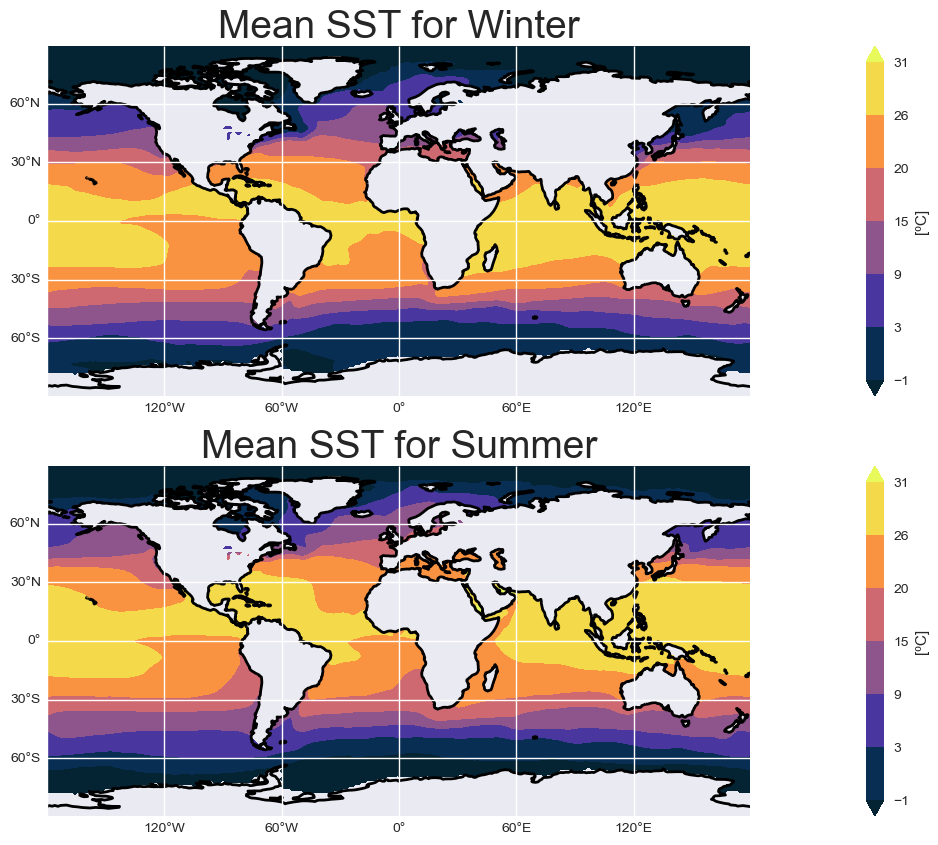

In [159]:
fig = plt.figure(figsize=(30,10)) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())

levels1 = np.linspace(np.min(np.array([np.min(winter),np.min(summer)])),np.max(np.array([np.max(winter),np.max(summer)])),num=7).astype(int)
dibujo_1_mapa_cartopy(winter,lon,lat,cmo.cm.thermal,'[ºC]','Mean SST for Winter', ax1,levels1)
dibujo_1_mapa_cartopy(summer,lon,lat,cmo.cm.thermal,'[ºC]','Mean SST for Summer', ax2,levels1)




C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


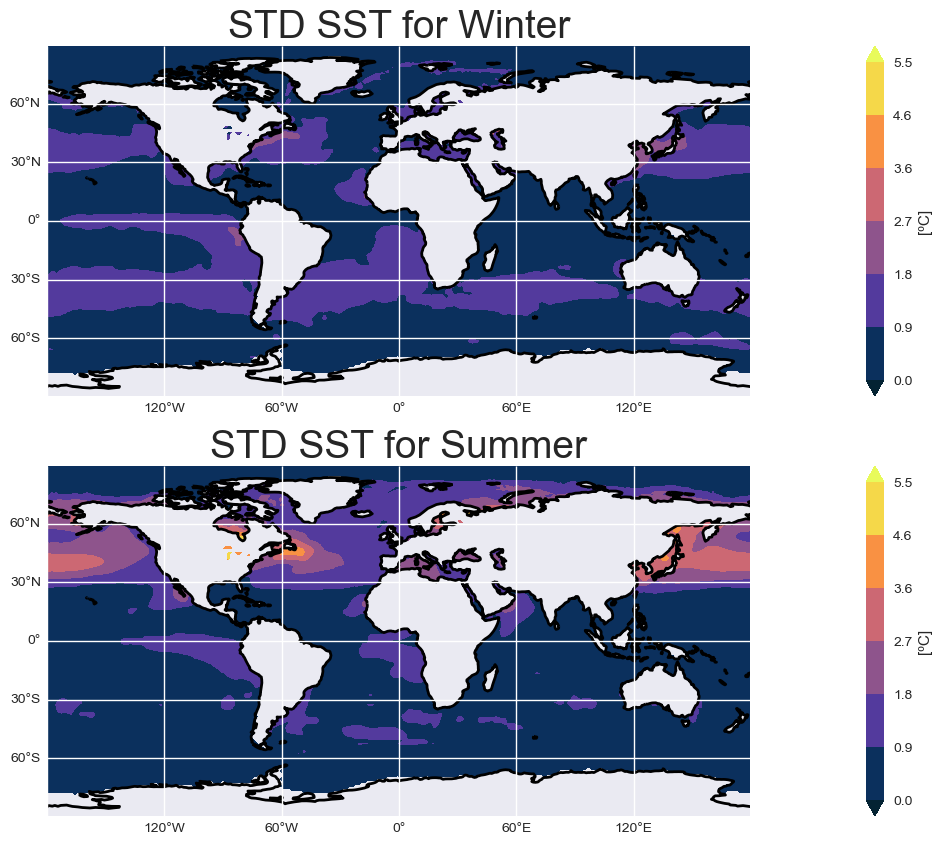

In [88]:
fig = plt.figure(figsize=(30,10)) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())

levels2 = np.round(np.linspace(np.min(np.array([np.min(winter_std),np.min(summer_std)])),np.max(np.array([np.max(winter_std),np.max(summer_std)])),num=7),decimals=1)
dibujo_1_mapa_cartopy(winter_std,lon,lat,cmo.cm.thermal,'[ºC]','STD SST for Winter', ax1,levels2)
dibujo_1_mapa_cartopy(summer_std,lon,lat,cmo.cm.thermal,'[ºC]','STD SST for Summer', ax2,levels2)

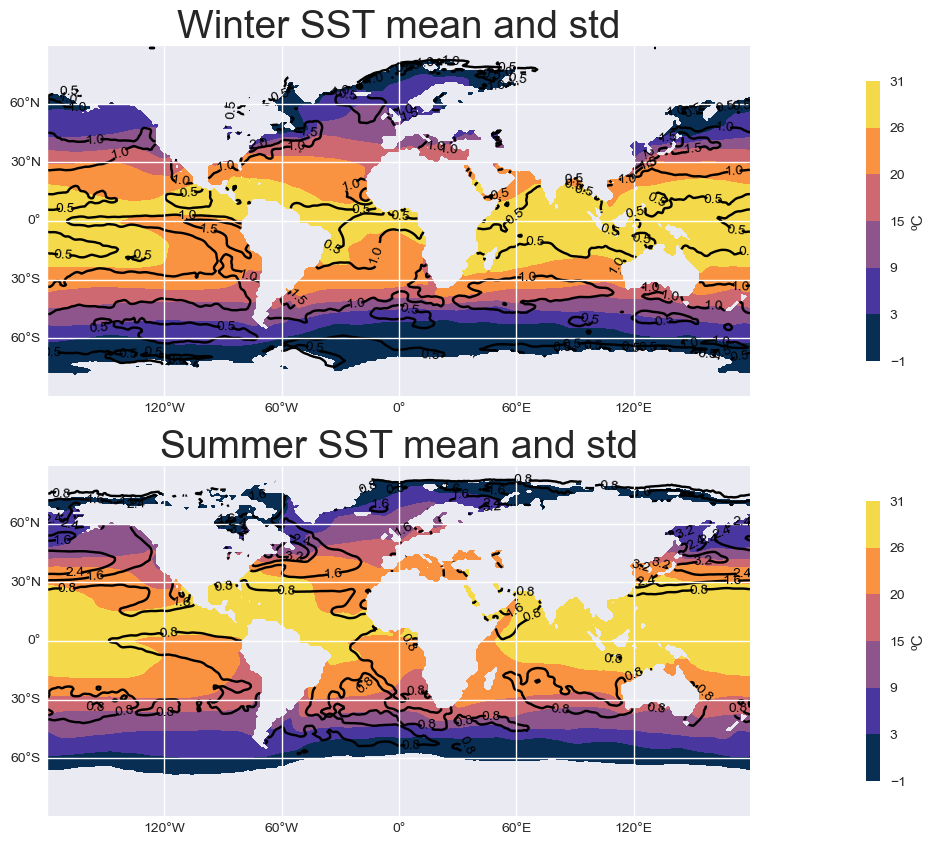

In [106]:
def DibujoMapaHorizontal(lon,lat,var1,var2,levels1,levels2, mapbar,unidades, titulo,ax):
    im=ax.contourf(lon,lat,var1,levels1, cmap = mapbar)
    ax.coastlines(linewidth = 0)
    ax.set_title(titulo,fontsize=28)
    gl= ax.gridlines(draw_labels = True)
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig.colorbar(im,ax=ax,shrink=0.8, label = unidades)
    im2=ax.contour(lon,lat,var2, colors='black')
    ax.clabel(im2, im2.levels, inline=True, fontsize=10)


    
fig = plt.figure(figsize=(30,10)) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())

DibujoMapaHorizontal(lon,lat,winter,winter_std,levels1,levels2,cmo.cm.thermal,'ºC','Winter SST mean and std',ax1)
DibujoMapaHorizontal(lon,lat,summer,summer_std,levels1,levels2,cmo.cm.thermal,'ºC','Summer SST mean and std',ax2)

### 2.2. Mean differences and variance rates 

In [161]:
sst.sst

<xarray.DataArray 'sst' (time: 1800, latitude: 180, longitude: 360)>
[116640000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [162]:
#Periodos: 1870-1930,1931-1975,1976-2019.
first_period= sst.isel(time=np.where(sst['time.year']<1931)[0])
second_period= sst.isel(time=np.where((sst['time.year']>1930)&(sst['time.year']<1976))[0])
third_period= sst.isel(time=np.where((sst['time.year']>1975))[0])
third_period.sst[0,0,:].mean()

<xarray.DataArray 'sst' ()>
array(nan, dtype=float32)
Coordinates:
    latitude  float32 89.5
    time      datetime64[ns] 1976-01-16T12:00:00

In [197]:
first_period_mean= first_period.sst.mean(axis=0)
second_period_mean= second_period.sst.mean(axis=0)
third_period_mean= third_period.sst.mean(axis=0)
first_period_std= first_period.sst.std(axis=0)
second_period_std= second_period.sst.std(axis=0)
third_period_std= third_period.sst.std(axis=0)
third_period_std

C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ideapad 5 15ITL05\anaconda3\envs\Analisisdatosucm2\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'sst' (latitude: 180, longitude: 360)>
array([[8.4323278e-03, 2.1457672e-06, 8.8160494e-03, ..., 8.7951999e-03,
        8.6721368e-03, 8.4973630e-03],
       [4.0531158e-06, 3.9339066e-06, 3.8146973e-06, ..., 4.0531158e-06,
        4.0531158e-06, 4.0531158e-06],
       [5.7220459e-06, 5.6028366e-06, 5.3644180e-06, ..., 5.6028366e-06,
        5.4836273e-06, 5.3644180e-06],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5

In [205]:
n1= first_period.time.shape[0]
#ttest= sts.ttest_ind(first_period.sst[:,:,0],second_period.sst[:,:,0],axis=0,nan_policy='omit')

ttest= np.empty((360,180))
for i in range(0,360):
    ttest[i,:]= sts.ttest_ind(first_period.sst[:,:,i],second_period.sst[:,:,i],axis=0,nan_policy='omit').pvalue[0]
    
ttest

array([[1.86605652e-01, 1.86605652e-01, 1.86605652e-01, ...,
        1.86605652e-01, 1.86605652e-01, 1.86605652e-01],
       [2.44493366e-48, 2.44493366e-48, 2.44493366e-48, ...,
        2.44493366e-48, 2.44493366e-48, 2.44493366e-48],
       [2.44493366e-48, 2.44493366e-48, 2.44493366e-48, ...,
        2.44493366e-48, 2.44493366e-48, 2.44493366e-48],
       ...,
       [1.86605652e-01, 1.86605652e-01, 1.86605652e-01, ...,
        1.86605652e-01, 1.86605652e-01, 1.86605652e-01],
       [1.86605652e-01, 1.86605652e-01, 1.86605652e-01, ...,
        1.86605652e-01, 1.86605652e-01, 1.86605652e-01],
       [1.86605652e-01, 1.86605652e-01, 1.86605652e-01, ...,
        1.86605652e-01, 1.86605652e-01, 1.86605652e-01]])

In [204]:
np.max(ttest)

nan